In [1]:
import scipy.io as sio
import dotenv
import os
import numpy as np
import umap
from sklearn.decomposition import PCA

from scipy.signal import butter, filtfilt


from util import plot_barcode
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams, wasserstein

dotenv.load_dotenv()

INPUT_FOLDER = os.getenv("INPUT_FOLDER")

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data visualization

## Bilateral

ECoG shape: (1024398, 64)
ECoG dtype: float64
ECoG min: -3413.33
ECoG max: 2671.98
ECoG mean: 0.08538006834257779
ECoG std: 260.8560070736566


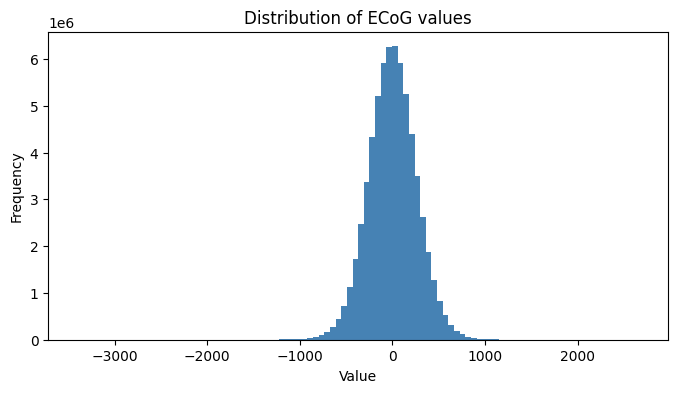

In [ ]:
data = sio.loadmat(f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-07-12_(S1)/ECoG.mat")

# Concatenate all ecog arrays along the time/sample axis
ecog = data["ECoG"]
time = data["ECoG_time"]
print("ECoG shape:", ecog.shape)
print("ECoG dtype:", ecog.dtype)
print("ECoG min:", np.min(ecog))
print("ECoG max:", np.max(ecog))
print("ECoG mean:", np.mean(ecog))
print("ECoG std:", np.std(ecog))


plt.figure(figsize=(8, 4))
plt.hist(ecog.flatten(), bins=100, color="steelblue")
plt.title("Distribution of ECoG values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
ecog = data["ECoG"]
time = data["ECoG_time"]
fs = float(data["Fs"].squeeze())  # Sampling frequency

# Band-pass filter design (1-100 Hz)
lowcut = 1.0
highcut = 100.0
order = 4
nyq = fs / 2
b, a = butter(order, [lowcut / nyq, highcut / nyq], btype="band")

# Apply filter to each channel (axis 1: samples)
ecog_filtered = filtfilt(b, a, ecog, axis=0)

# Z-score normalization of each channel (over time/samples)
ecog_zscored = (ecog_filtered - np.mean(ecog_filtered, axis=0, keepdims=True)) / np.std(
    ecog_filtered, axis=0, keepdims=True
)

# Replace ecog with z-scored, filtered version for subsequent use
ecog = ecog_zscored

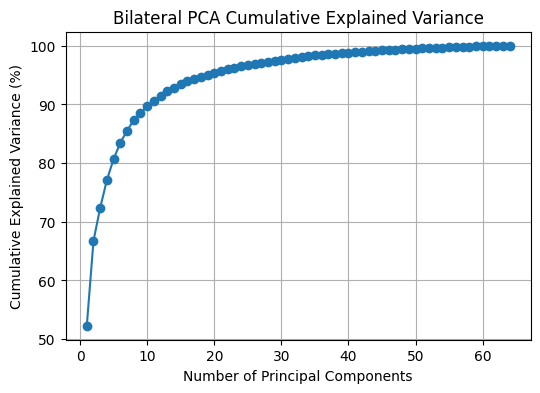

Explained variance by first 11 PCs: 0.906284330230974


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


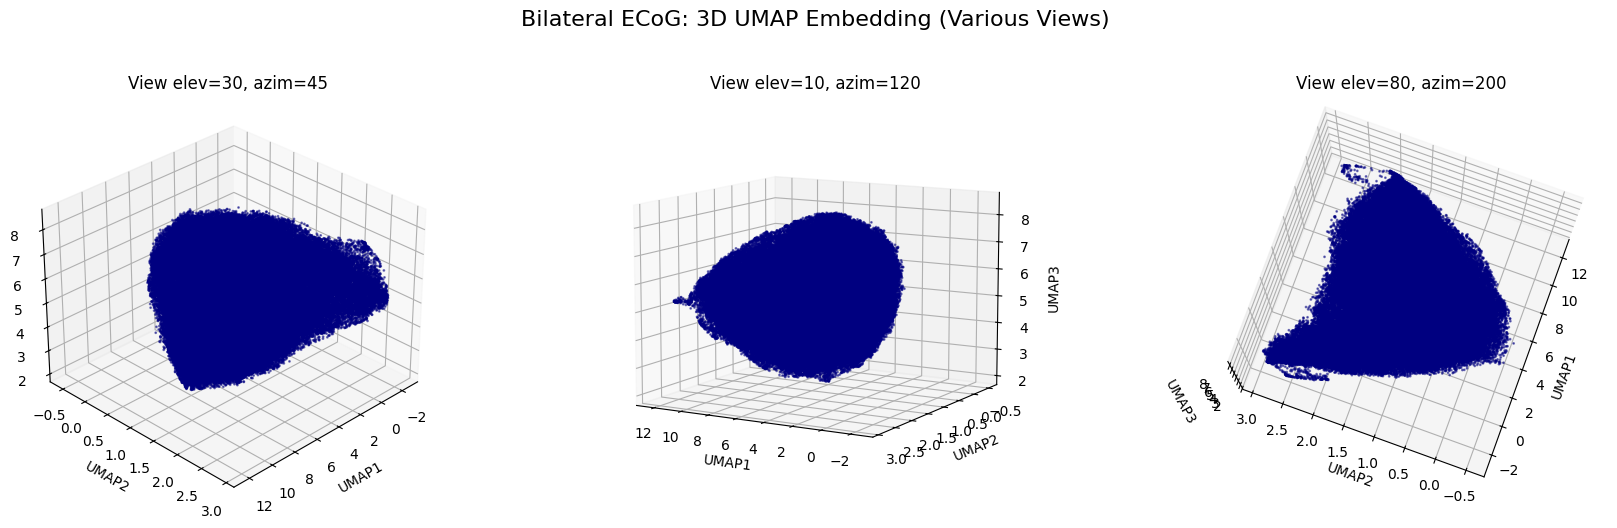

In [ ]:
# ecog shape: (n_channels, n_samples)
# We'll treat time (samples) as data points and channels as features for PCA.
# So, transpose to (n_samples, n_channels)
X = ecog

# Apply PCA with enough components to explain >99% variance, and plot cumulative explained variance
pca_full = PCA(n_components=min(X.shape[0], X.shape[1]))
X_pca_full = pca_full.fit_transform(X)
explained_var = pca_full.explained_variance_ratio_

plt.figure(figsize=(6, 4))
plt.plot(
    np.arange(1, len(explained_var) + 1), np.cumsum(explained_var) * 100, marker="o"
)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Bilateral PCA Cumulative Explained Variance")
plt.grid(True)
plt.show()


# Apply PCA, retain first 6 principal components
n_components = np.argmax(np.cumsum(explained_var) > 0.9) + 1
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

print(
    f"Explained variance by first {n_components} PCs:",
    np.sum(pca.explained_variance_ratio_),
)


umap_reducer = umap.UMAP(n_components=3, random_state=42)
X_umap = umap_reducer.fit_transform(X_pca[::10])  # shape: (n_samples, 3)


fig = plt.figure(figsize=(18, 5))
angles = [(30, 45), (10, 120), (80, 200)]  # List of (elev, azim)

fig.suptitle("Bilateral ECoG: 3D UMAP Embedding (Various Views)", fontsize=16, y=1.03)
for i, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(1, len(angles), i + 1, projection="3d")
    ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], s=1, c="navy", alpha=0.5)
    ax.set_title(f"View elev={elev}, azim={azim}")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_zlabel("UMAP3")
    ax.view_init(elev=elev, azim=azim)

plt.tight_layout()
plt.show()


(1025, 3)


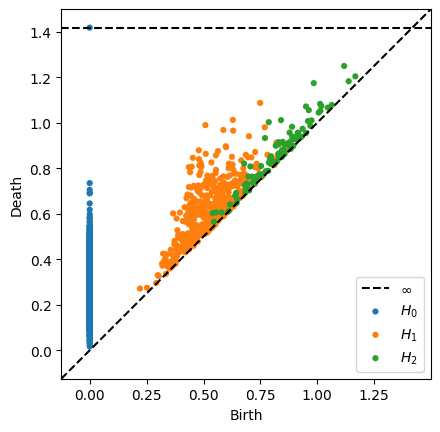

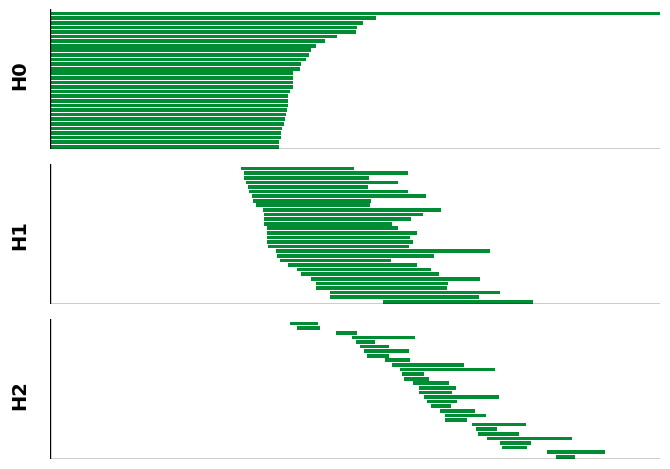

In [ ]:
data = X_umap[::100]

print(data.shape)
maxdim = 2
diagrams = ripser(data, maxdim=maxdim)["dgms"]

# Show both persistence diagrams and barcodes (lifetimes)
plot_diagrams(diagrams, show=True)
plot_barcode(diagrams)

plt.tight_layout()
plt.show()

## Contralateral

ECoG shape: (907298, 64)
ECoG dtype: float64
ECoG min: -3413.33
ECoG max: 2355.21
ECoG mean: 0.6554025494862218
ECoG std: 276.6185245184147


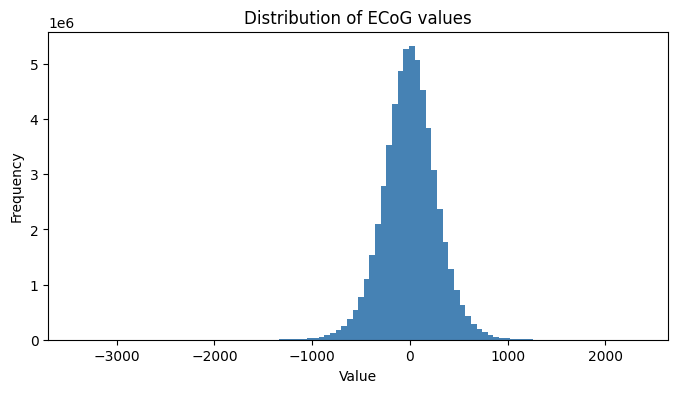

In [6]:
data = sio.loadmat(f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-03-15_(S1)/ECoG.mat")

# Concatenate all ecog arrays along the time/sample axis
ecog = data["ECoG"]
time = data["ECoG_time"]
print("ECoG shape:", ecog.shape)
print("ECoG dtype:", ecog.dtype)
print("ECoG min:", np.min(ecog))
print("ECoG max:", np.max(ecog))
print("ECoG mean:", np.mean(ecog))
print("ECoG std:", np.std(ecog))

plt.figure(figsize=(8, 4))
plt.hist(ecog.flatten(), bins=100, color="steelblue")
plt.title("Distribution of ECoG values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
ecog = data["ECoG"]
time = data["ECoG_time"]
fs = float(data["Fs"].squeeze())  # Sampling frequency

# Band-pass filter design (1-100 Hz)
lowcut = 1.0
highcut = 100.0
order = 4
nyq = fs / 2
b, a = butter(order, [lowcut / nyq, highcut / nyq], btype="band")

# Apply filter to each channel (axis 1: samples)
ecog_filtered = filtfilt(b, a, ecog, axis=0)

# Z-score normalization of each channel (over time/samples)
ecog_zscored = (ecog_filtered - np.mean(ecog_filtered, axis=0, keepdims=True)) / np.std(
    ecog_filtered, axis=0, keepdims=True
)

# Replace ecog with z-scored, filtered version for subsequent use
ecog = ecog_zscored

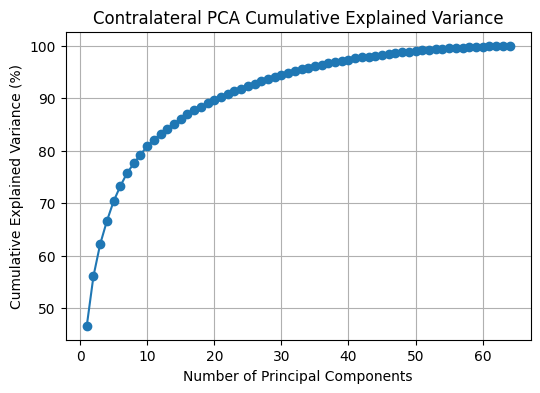

Explained variance by first 21 PCs: 0.9024234041040152


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


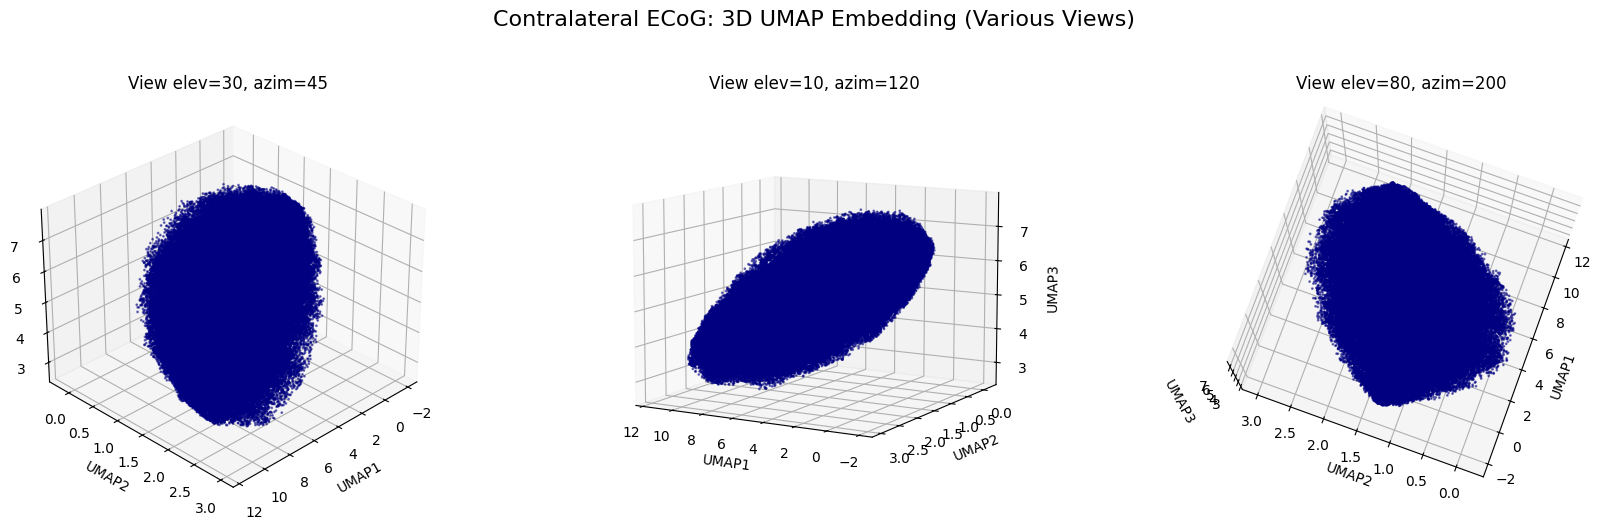

In [ ]:
# ecog shape: (n_channels, n_samples)
# We'll treat time (samples) as data points and channels as features for PCA.
# So, transpose to (n_samples, n_channels)
X = ecog

# Apply PCA with enough components to explain >99% variance, and plot cumulative explained variance
pca_full = PCA(n_components=min(X.shape[0], X.shape[1]))
X_pca_full = pca_full.fit_transform(X)
explained_var = pca_full.explained_variance_ratio_

plt.figure(figsize=(6, 4))
plt.plot(
    np.arange(1, len(explained_var) + 1), np.cumsum(explained_var) * 100, marker="o"
)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Contralateral PCA Cumulative Explained Variance")
plt.grid(True)
plt.show()

# Apply PCA, retain first 6 principal components
n_components = np.argmax(np.cumsum(explained_var) > 0.9) + 1
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

print(
    f"Explained variance by first {n_components} PCs:",
    np.sum(pca.explained_variance_ratio_),
)

# Now reduce to 3D with UMAP for visualization
umap_reducer = umap.UMAP(n_components=3, random_state=42)
X_umap = umap_reducer.fit_transform(X_pca[::10])  # shape: (n_samples, 3)


fig = plt.figure(figsize=(18, 5))
angles = [(30, 45), (10, 120), (80, 200)]  # List of (elev, azim)

fig.suptitle(
    "Contralateral ECoG: 3D UMAP Embedding (Various Views)", fontsize=16, y=1.03
)
for i, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(1, len(angles), i + 1, projection="3d")
    ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], s=1, c="navy", alpha=0.5)
    ax.set_title(f"View elev={elev}, azim={azim}")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_zlabel("UMAP3")
    ax.view_init(elev=elev, azim=azim)

plt.tight_layout()
plt.show()


(908, 3)


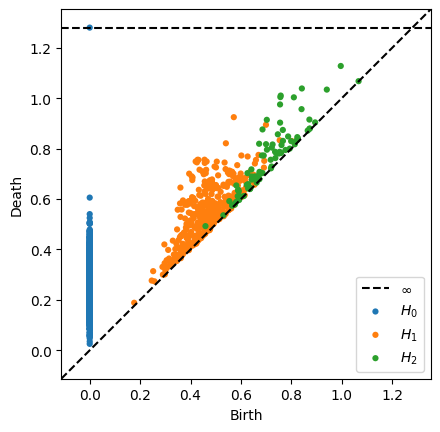

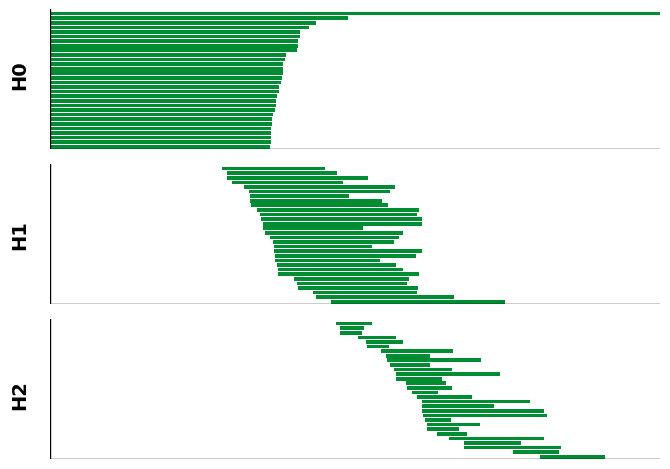

In [ ]:
data = X_umap[::100]

print(data.shape)
maxdim = 2
diagrams = ripser(data, maxdim=maxdim)["dgms"]

# Show both persistence diagrams and barcodes (lifetimes)
plot_diagrams(diagrams, show=True)
plot_barcode(diagrams)

plt.tight_layout()
plt.show()

## Ipsilateral

ECoG shape: (920498, 64)
ECoG dtype: float64
ECoG min: -3413.33
ECoG max: 3413.23
ECoG mean: 0.6948211671155179
ECoG std: 943.3876852401362


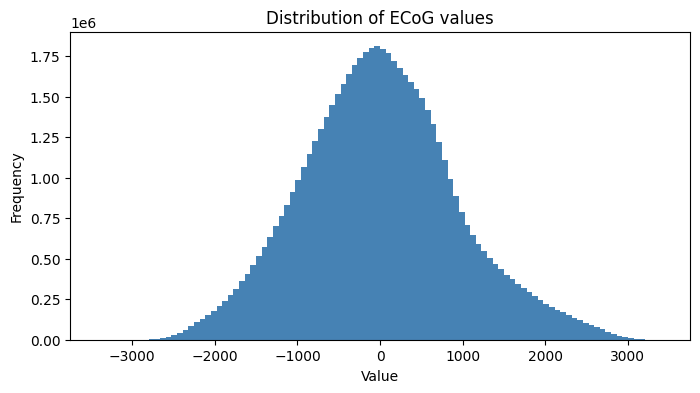

In [ ]:
data = sio.loadmat(f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-04-29_(S1)/ECoG.mat")

# Concatenate all ecog arrays along the time/sample axis
ecog = data["ECoG"]
time = data["ECoG_time"]
print("ECoG shape:", ecog.shape)
print("ECoG dtype:", ecog.dtype)
print("ECoG min:", np.min(ecog))
print("ECoG max:", np.max(ecog))
print("ECoG mean:", np.mean(ecog))
print("ECoG std:", np.std(ecog))

plt.figure(figsize=(8, 4))
plt.hist(ecog.flatten(), bins=100, color="steelblue")
plt.title("Distribution of ECoG values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [ ]:
ecog = data["ECoG"]
time = data["ECoG_time"]
fs = float(data["Fs"].squeeze())  # Sampling frequency

# Band-pass filter design (1-100 Hz)
lowcut = 1.0
highcut = 100.0
order = 4
nyq = fs / 2
b, a = butter(order, [lowcut / nyq, highcut / nyq], btype="band")

# Apply filter to each channel (axis 1: samples)
ecog_filtered = filtfilt(b, a, ecog, axis=0)

# Z-score normalization of each channel (over time/samples)
ecog_zscored = (ecog_filtered - np.mean(ecog_filtered, axis=0, keepdims=True)) / np.std(
    ecog_filtered, axis=0, keepdims=True
)

# Replace ecog with z-scored, filtered version for subsequent use
ecog = ecog_zscored

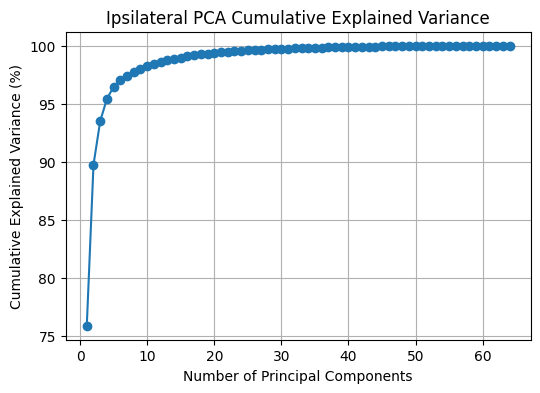

Explained variance by first 3 PCs: 0.9350689533770542


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


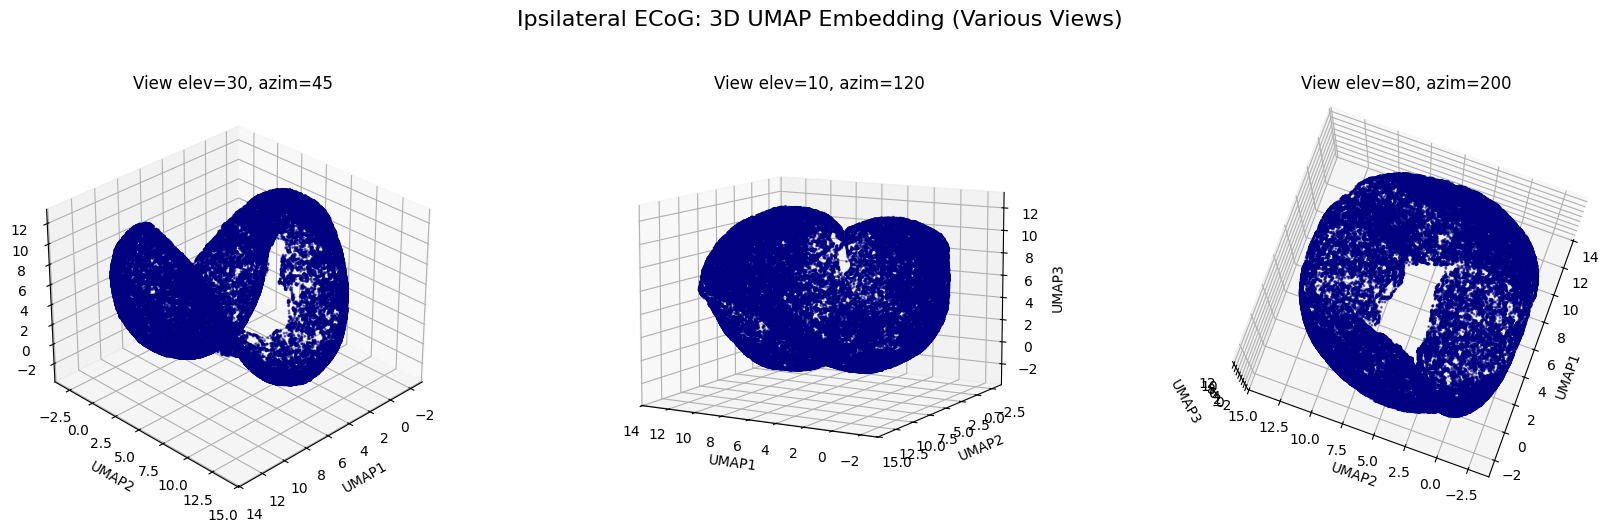

In [ ]:
# ecog shape: (n_channels, n_samples)
# We'll treat time (samples) as data points and channels as features for PCA.
# So, transpose to (n_samples, n_channels)
X = ecog

# Apply PCA with enough components to explain >99% variance, and plot cumulative explained variance
pca_full = PCA(n_components=min(X.shape[0], X.shape[1]))
X_pca_full = pca_full.fit_transform(X)
explained_var = pca_full.explained_variance_ratio_

plt.figure(figsize=(6, 4))
plt.plot(
    np.arange(1, len(explained_var) + 1), np.cumsum(explained_var) * 100, marker="o"
)
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance (%)")
plt.title("Ipsilateral PCA Cumulative Explained Variance")
plt.grid(True)
plt.show()

# For downstream steps, keep only compontents that explain >90% of variance
n_components = np.argmax(np.cumsum(explained_var) > 0.9) + 1
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

print(
    f"Explained variance by first {n_components} PCs:",
    np.sum(pca.explained_variance_ratio_),
)


umap_reducer = umap.UMAP(n_components=3, random_state=42)
X_umap = umap_reducer.fit_transform(X_pca[::10])  # shape: (n_samples, 3)


fig = plt.figure(figsize=(18, 5))
angles = [(30, 45), (10, 120), (80, 200)]  # List of (elev, azim)

fig.suptitle("Ipsilateral ECoG: 3D UMAP Embedding (Various Views)", fontsize=16, y=1.03)
for i, (elev, azim) in enumerate(angles):
    ax = fig.add_subplot(1, len(angles), i + 1, projection="3d")
    ax.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], s=1, c="navy", alpha=0.5)
    ax.set_title(f"View elev={elev}, azim={azim}")
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    ax.set_zlabel("UMAP3")
    ax.view_init(elev=elev, azim=azim)

plt.tight_layout()
plt.show()


(921, 3)


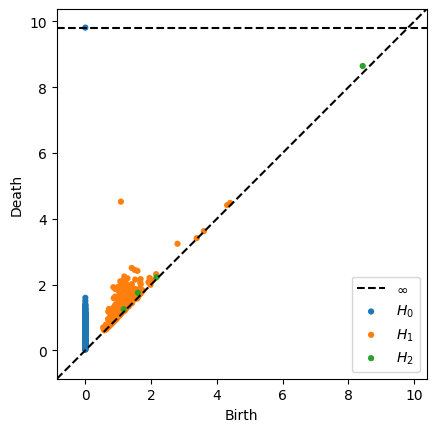

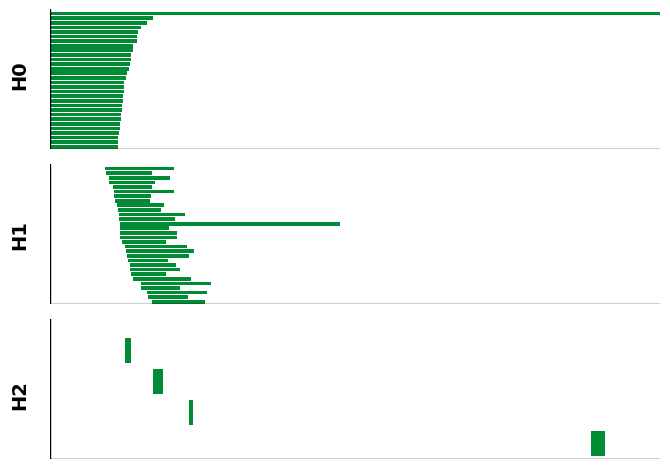

In [ ]:
data = X_umap[::100]

print(data.shape)
maxdim = 2
diagrams = ripser(data, maxdim=maxdim)["dgms"]

# Show both persistence diagrams and barcodes (lifetimes)
plot_diagrams(diagrams, show=True)
plot_barcode(diagrams)

plt.tight_layout()
plt.show()

# Comparison

In [5]:
def preprocess_ecog(data):
    ecog = data["ECoG"]
    fs = float(data["Fs"].squeeze())  # Sampling frequency

    # Band-pass filter design (1-100 Hz)
    lowcut = 1.0
    highcut = 100.0
    order = 4
    nyq = fs / 2
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype="band")
    ecog_filtered = filtfilt(b, a, ecog, axis=0)
    ecog_zscored = (
        ecog_filtered - np.mean(ecog_filtered, axis=0, keepdims=True)
    ) / np.std(ecog_filtered, axis=0, keepdims=True)
    return ecog_zscored


def project_ecog(ecog):
    # Apply PCA with enough components to explain >99% variance, and plot cumulative explained variance
    pca_full = PCA(n_components=min(ecog.shape[0], ecog.shape[1]))
    ecog_pca_full = pca_full.fit_transform(ecog)
    explained_var = pca_full.explained_variance_ratio_

    # Apply PCA, retain first 6 principal components
    n_components = np.argmax(np.cumsum(explained_var) > 0.9) + 1
    pca = PCA(n_components=n_components)
    ecog_pca = pca.fit_transform(ecog)

    umap_reducer = umap.UMAP(n_components=3, random_state=42)
    ecog_umap = umap_reducer.fit_transform(ecog_pca[::10])  # shape: (n_samples, 3)
    return ecog_umap


def wasserstein_distance(diagrams1, diagrams2):
    """
    Compute Wasserstein distance between two sets of persistence diagrams.
    diagrams1 and diagrams2 are lists of diagrams (one per dimension from ripser).
    Returns a dictionary with distances for each dimension.
    """
    distances = {}
    for dim in range(len(diagrams1)):
        dgm1 = diagrams1[dim]
        dgm2 = diagrams2[dim]
        distances[dim] = wasserstein(dgm1, dgm2)
    
    return distances


## Distance between different data types

In [ ]:
ipsi_data = sio.loadmat(f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-04-29_(S1)/ECoG.mat")
contra_data = sio.loadmat(
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-03-15_(S1)/ECoG.mat"
)
bilat_data = sio.loadmat(f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-07-12_(S1)/ECoG.mat")

ipsi_ecog = ipsi_data["ECoG"]
contra_ecog = contra_data["ECoG"]
bilat_ecog = bilat_data["ECoG"]


ipsi_ecog_zscored = preprocess_ecog(ipsi_data)
contra_ecog_zscored = preprocess_ecog(contra_data)
bilat_ecog_zscored = preprocess_ecog(bilat_data)


ipsi_ecog_umap = project_ecog(ipsi_ecog_zscored)
contra_ecog_umap = project_ecog(contra_ecog_zscored)
bilat_ecog_umap = project_ecog(bilat_ecog_zscored)

maxdim = 2

ipsi_diagrams = ripser(ipsi_ecog_umap[::100], maxdim=maxdim)["dgms"]
contra_diagrams = ripser(contra_ecog_umap[::100], maxdim=maxdim)["dgms"]
bilat_diagrams = ripser(bilat_ecog_umap[::100], maxdim=maxdim)["dgms"]

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ig

Wasserstein distance (Ipsi vs Contra):
  H0: 238.0905
  H1: 63.3488
  H2: 3.5222

Wasserstein distance (Ipsi vs Bilat):
  H0: 210.3903
  H1: 67.1772
  H2: 2.9410

Wasserstein distance (Contra vs Bilat):
  H0: 50.0898
  H1: 14.8006
  H2: 2.6265


In [ ]:
# Compute Wasserstein distance between all pairs
wd_ipsi_contra = wasserstein_distance(ipsi_diagrams, contra_diagrams)
wd_ipsi_bilat = wasserstein_distance(ipsi_diagrams, bilat_diagrams)
wd_contra_bilat = wasserstein_distance(contra_diagrams, bilat_diagrams)

print("Wasserstein distance (Ipsi vs Contra):")
for dim, dist in wd_ipsi_contra.items():
    print(f"  H{dim}: {dist:.4f}")

print("\nWasserstein distance (Ipsi vs Bilat):")
for dim, dist in wd_ipsi_bilat.items():
    print(f"  H{dim}: {dist:.4f}")

print("\nWasserstein distance (Contra vs Bilat):")
for dim, dist in wd_contra_bilat.items():
    print(f"  H{dim}: {dist:.4f}")

Wasserstein distance (Ipsi vs Contra):
  H0: 238.0905
  H1: 63.3488
  H2: 3.5222

Wasserstein distance (Ipsi vs Bilat):
  H0: 210.3903
  H1: 67.1772
  H2: 2.9410

Wasserstein distance (Contra vs Bilat):
  H0: 50.0898
  H1: 14.8006
  H2: 2.6265


## Distances between the same data types

In [8]:
ipsi_data_2 = sio.loadmat(f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-04-29_(S2)/ECoG.mat")
contra_data_2 = sio.loadmat(
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-08_(S2)/ECoG.mat"
)
bilat_data_2 = sio.loadmat(f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-07-19_(S2)/ECoG.mat")

ipsi_ecog_2 = ipsi_data_2["ECoG"]
contra_ecog_2 = contra_data_2["ECoG"]
bilat_ecog_2 = bilat_data_2["ECoG"]


ipsi_ecog_zscored_2 = preprocess_ecog(ipsi_data_2)
contra_ecog_zscored_2 = preprocess_ecog(contra_data_2)
bilat_ecog_zscored_2 = preprocess_ecog(bilat_data_2)


ipsi_ecog_umap_2 = project_ecog(ipsi_ecog_zscored_2)
contra_ecog_umap_2 = project_ecog(contra_ecog_zscored_2)
bilat_ecog_umap_2 = project_ecog(bilat_ecog_zscored_2)

maxdim = 2

ipsi_diagrams_2 = ripser(ipsi_ecog_umap_2[::100], maxdim=maxdim)["dgms"]
contra_diagrams_2 = ripser(contra_ecog_umap_2[::100], maxdim=maxdim)["dgms"]
bilat_diagrams_2 = ripser(bilat_ecog_umap_2[::100], maxdim=maxdim)["dgms"]

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [9]:
# Compute Wasserstein distance between all pairs
wd_ipsi_ipsi2 = wasserstein_distance(ipsi_diagrams, ipsi_diagrams_2)
wd_contra_contra2 = wasserstein_distance(contra_diagrams, contra_diagrams_2)
wd_bilat_bilat2 = wasserstein_distance(bilat_diagrams, bilat_diagrams_2)

print("Wasserstein distance (Ipsi vs Ipsi_2):")
for dim, dist in wd_ipsi_ipsi2.items():
    print(f"  H{dim}: {dist:.4f}")

print("\nWasserstein distance (Contra vs Contra_2):")
for dim, dist in wd_contra_contra2.items():
    print(f"  H{dim}: {dist:.4f}")

print("\nWasserstein distance (Bilateral vs Bilateral_2):")
for dim, dist in wd_bilat_bilat2.items():
    print(f"  H{dim}: {dist:.4f}")

/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those points
  warnings.warn(
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/persim/wasserstein.py:61: UserWarning: dgm2 has points with non-finite death times;ignoring those points
  warnings.warn(
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/persim/wasserstein.py:51: UserWarning: dgm1 has points with non-finite death times;ignoring those

Wasserstein distance (Ipsi vs Ipsi_2):
  H0: 172.1473
  H1: 47.5223
  H2: 2.9474

Wasserstein distance (Contra vs Contra_2):
  H0: 78.8195
  H1: 27.0930
  H2: 4.1047

Wasserstein distance (Bilateral vs Bilateral_2):
  H0: 11.7288
  H1: 7.0908
  H2: 2.1333


# Classifier

## Data preprocessing

In [ ]:
from persim import PersistenceImager
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

ipsi_data_list = [
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-04-29_(S1)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-04-29_(S2)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-03_(S3)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-03_(S4)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-03_(S5)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-06_(S6)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-10_(S7)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-10_(S8)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-17_(S9)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Ipsilateral/2018-05-24_(S10)/ECoG.mat",
]

contra_data_list = [
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-03-15_(S1)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-08_(S2)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-12_(S3)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-12_(S4)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-12_(S5)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-15_(S6)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-22_(S7)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-22_(S8)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-04-22_(S9)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Contralateral/2018-05-31_(S10)/ECoG.mat",
]

bilat_data_list = [
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-07-12_(S1)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-07-19_(S2)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-07-26_(S3)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-08-14_(S4)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-09-27_(S5)/ECoG.mat",
    f"{INPUT_FOLDER}/CRCNS/Bilateral/2018-10-04_(S6)/ECoG.mat",
]


y = []  # labels: 0=ipsi, 1=contra, 2=bilat
all_h0_diagrams = []  # Collect all H1 diagrams to fit the imager
all_h1_diagrams = []  # Collect all H2 diagrams to fit the imager
all_h2_diagrams = []  # Collect all H3 diagrams to fit the imager

maxdim = 2
subsample_step = 100  # Subsample the projected data

print("Processing data and computing persistence diagrams...")

# Process Ipsilateral data
for data_path in ipsi_data_list:
    data = sio.loadmat(data_path)
    ecog_preprocessed = preprocess_ecog(data)
    ecog_projected = project_ecog(ecog_preprocessed)

    # Subsample for computational efficiency
    data_subsampled = ecog_projected[::subsample_step]

    # Compute persistence diagrams
    dgms = ripser(data_subsampled, maxdim=maxdim)["dgms"]

    # Collect H1 diagram for fitting the imager
    all_h0_diagrams.append(dgms[0])
    all_h1_diagrams.append(dgms[1])
    all_h2_diagrams.append(dgms[2])
    y.append(0)  # Label: ipsi
    print(f"  Processed: {data_path.split('/')[-2]} (ipsi)")

# Process Contralateral data
for data_path in contra_data_list:
    data = sio.loadmat(data_path)
    ecog_preprocessed = preprocess_ecog(data)
    ecog_projected = project_ecog(ecog_preprocessed)

    # Subsample for computational efficiency
    data_subsampled = ecog_projected[::subsample_step]

    # Compute persistence diagrams
    dgms = ripser(data_subsampled, maxdim=maxdim)["dgms"]

    # Collect H1 diagram for fitting the imager
    all_h0_diagrams.append(dgms[0])
    all_h1_diagrams.append(dgms[1])
    all_h2_diagrams.append(dgms[2])
    y.append(1)  # Label: contra
    print(f"  Processed: {data_path.split('/')[-2]} (contra)")

# Process Bilateral data
for data_path in bilat_data_list:
    data = sio.loadmat(data_path)
    ecog_preprocessed = preprocess_ecog(data)
    ecog_projected = project_ecog(ecog_preprocessed)

    # Subsample for computational efficiency
    data_subsampled = ecog_projected[::subsample_step]

    # Compute persistence diagrams
    dgms = ripser(data_subsampled, maxdim=maxdim)["dgms"]

    # Collect H1 diagram for fitting the imager
    all_h0_diagrams.append(dgms[0])
    all_h1_diagrams.append(dgms[1])
    all_h2_diagrams.append(dgms[2])
    y.append(2)  # Label: bilat
    print(f"  Processed: {data_path.split('/')[-2]} (bilat)")

Processing data and computing persistence diagrams...


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-29_(S1) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-29_(S2) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-03_(S3) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-03_(S4) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-03_(S5) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-06_(S6) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-10_(S7) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-10_(S8) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-17_(S9) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-24_(S10) (ipsi)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-03-15_(S1) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-08_(S2) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-12_(S3) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-12_(S4) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-12_(S5) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-15_(S6) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-22_(S7) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-22_(S8) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-04-22_(S9) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-05-31_(S10) (contra)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-07-12_(S1) (bilat)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-07-19_(S2) (bilat)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-07-26_(S3) (bilat)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-08-14_(S4) (bilat)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-09-27_(S5) (bilat)


/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


  Processed: 2018-10-04_(S6) (bilat)


## Classification part

### H1

In [96]:
from sklearn.base import BaseEstimator, TransformerMixin

class PersistenceImageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pixel_size=0.1):
        self.pixel_size = pixel_size
        self.pimgr = PersistenceImager(pixel_size=pixel_size)

    def fit(self, X, y=None):
        # X is a list of persistence diagrams
        self.pimgr.fit(X)
        return self

    def transform(self, X):
        return np.array([self.pimgr.transform(d).flatten() for d in X])

In [149]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

X_h1 = []

# Initialize PersistenceImager
pimgr = PersistenceImager(pixel_size=0.1)

print(
    f"Labels: {len(y)} samples ({np.sum(y == 0)} ipsi, {np.sum(y == 1)} contra, {np.sum(y == 2)} bilat)"
)

# Split into train and test sets
X_train_h1, X_test_h1, y_train_h1, y_test_h1 = train_test_split(
    all_h1_diagrams, y, test_size=0.3, stratify=y
)

# Fit the PersistenceImager on all H1 diagrams to determine proper ranges
print("\nFitting PersistenceImager on train diagrams...")
pimgr.fit(X_train_h1)

X_train_h1 = [pimgr.transform(d).flatten() for d in X_train_h1]
X_test_h1 = [pimgr.transform(d).flatten() for d in X_test_h1]

# Train SVM classifier
print("\nTraining SVM classifier...")
clf = make_pipeline(StandardScaler(), SVC(kernel="linear"))
clf.fit(X_train_h1, y_train_h1)

# Evaluate on test set
y_pred_h1 = clf.predict(X_test_h1)
accuracy_h1 = clf.score(X_test_h1, y_test_h1)

print(f"\nTest Accuracy: {accuracy_h1:.4f}")
print("\nClassification Report:")
print(
    classification_report(
        y_test_h1, y_pred_h1, target_names=["Ipsi", "Contra", "Bilat"]
    )
)

pipe = Pipeline(
    [
        ("pi", PersistenceImageTransformer(pixel_size=0.1)),
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="linear")),
    ]
)


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe,
    all_h1_diagrams,  # raw diagrams
    y,
    cv=cv,
    scoring="accuracy",
)

print("CV accuracy:", scores.mean(), "+/-", scores.std())

Labels: 26 samples (10 ipsi, 10 contra, 6 bilat)

Fitting PersistenceImager on train diagrams...

Training SVM classifier...

Test Accuracy: 0.6250

Classification Report:
              precision    recall  f1-score   support

        Ipsi       1.00      0.67      0.80         3
      Contra       0.50      1.00      0.67         3
       Bilat       0.00      0.00      0.00         2

    accuracy                           0.62         8
   macro avg       0.50      0.56      0.49         8
weighted avg       0.56      0.62      0.55         8



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control 

CV accuracy: 0.5833333333333333 +/- 0.291070819942883


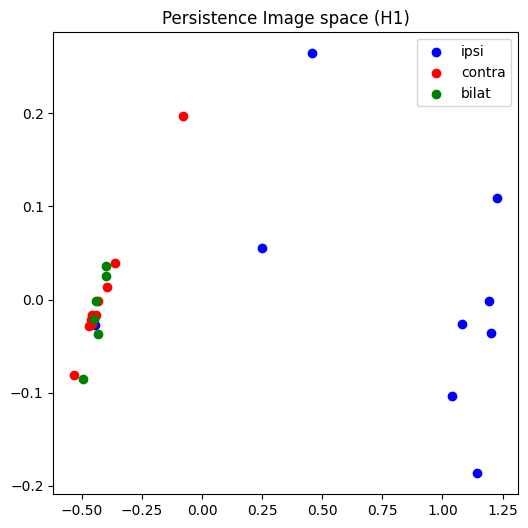

In [144]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = np.array([pimgr.transform(d).flatten() for d in all_h1_diagrams])
Xp = PCA(n_components=3).fit_transform(X)

plt.figure(figsize=(6,6))
for label, name, c in [(0,"ipsi","blue"), (1,"contra","red"), (2,"bilat","green")]:
    idx = y == label
    plt.scatter(Xp[idx,0], Xp[idx,1], label=name, c=c)

plt.legend()
plt.title("Persistence Image space (H1)")
plt.show()

### H2

In [155]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline

X_h2 = []

# Initialize PersistenceImager
pimgr = PersistenceImager(pixel_size=0.1)

print(
    f"Labels: {len(y)} samples ({np.sum(y == 0)} ipsi, {np.sum(y == 1)} contra, {np.sum(y == 2)} bilat)"
)

# Split into train and test sets
X_train_h2, X_test_h2, y_train_h2, y_test_h2 = train_test_split(
    all_h2_diagrams, y, test_size=0.3, stratify=y
)

# Fit the PersistenceImager on all H1 diagrams to determine proper ranges
print("\nFitting PersistenceImager on train diagrams...")
pimgr.fit(X_train_h2)

X_train_h2 = [pimgr.transform(d).flatten() for d in X_train_h2]
X_test_h2 = [pimgr.transform(d).flatten() for d in X_test_h2]

# Train SVM classifier
print("\nTraining SVM classifier...")
clf = make_pipeline(StandardScaler(), SVC(kernel="linear"))
clf.fit(X_train_h2, y_train_h2)

# Evaluate on test set
y_pred_h2 = clf.predict(X_test_h2)
accuracy_h2 = clf.score(X_test_h2, y_test_h2)

print(f"\nTest Accuracy: {accuracy_h2:.4f}")
print("\nClassification Report:")
print(
    classification_report(
        y_test_h2, y_pred_h2, target_names=["Ipsi", "Contra", "Bilat"]
    )
)

pipe = Pipeline(
    [
        ("pi", PersistenceImageTransformer(pixel_size=0.1)),
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="linear")),
    ]
)


cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

scores = cross_val_score(
    pipe,
    all_h2_diagrams,  # raw diagrams
    y,
    cv=cv,
    scoring="accuracy",
)

print("CV accuracy:", scores.mean(), "+/-", scores.std())

Labels: 26 samples (10 ipsi, 10 contra, 6 bilat)

Fitting PersistenceImager on train diagrams...

Training SVM classifier...

Test Accuracy: 0.7500

Classification Report:
              precision    recall  f1-score   support

        Ipsi       1.00      1.00      1.00         3
      Contra       0.67      0.67      0.67         3
       Bilat       0.50      0.50      0.50         2

    accuracy                           0.75         8
   macro avg       0.72      0.72      0.72         8
weighted avg       0.75      0.75      0.75         8



/Users/emil/Desktop/assignments/TDA/assignment2/.venv/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


CV accuracy: 0.6833333333333333 +/- 0.24094720491334934


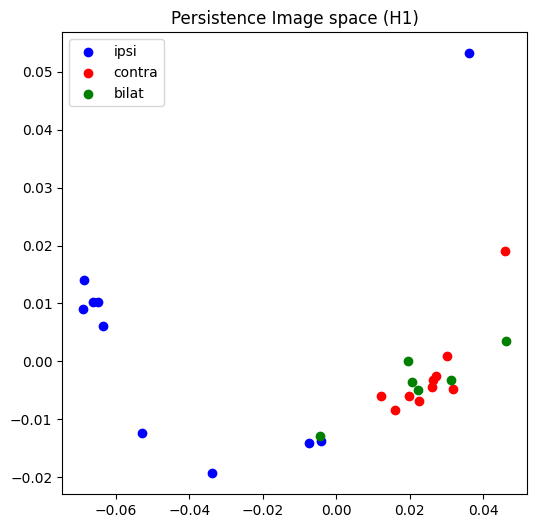

In [156]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = np.array([pimgr.transform(d).flatten() for d in all_h2_diagrams])
Xp = PCA(n_components=2).fit_transform(X)

plt.figure(figsize=(6,6))
for label, name, c in [(0,"ipsi","blue"), (1,"contra","red"), (2,"bilat","green")]:
    idx = y == label
    plt.scatter(Xp[idx,0], Xp[idx,1], label=name, c=c)

plt.legend()
plt.title("Persistence Image space (H1)")
plt.show()